# Backtest Of Exiting the Market During a Downtrend MACD Signal

## Import packages

In [5]:
import os
import sys
import json
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [6]:
parent_dir = os.path.join(os.getcwd(),"../src")
sys.path.insert(0, parent_dir)
from semi_utils import sql_queries as sqlq

### Focus on Soxx

In [7]:
engine = sqlq.get_sql_engine(os.path.join(os.getcwd(), '..','data', 'semi.db'))
soxx = pd.read_sql('SELECT * FROM soxx', engine)

soxx

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Capital Gains
0,2001-07-13 00:00:00.000000,20.030775,20.388171,19.554247,20.127743,603300,0.0,0.0,0.0
1,2001-07-16 00:00:00.000000,19.767572,19.822983,18.961355,18.961355,180000,0.0,0.0,0.0
2,2001-07-17 00:00:00.000000,18.825598,19.739866,18.811746,19.739866,287100,0.0,0.0,0.0
3,2001-07-18 00:00:00.000000,19.144212,19.285508,18.922571,18.922571,301800,0.0,0.0,0.0
4,2001-07-19 00:00:00.000000,20.058482,20.141597,19.726021,19.726021,405000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
5819,2024-08-30 00:00:00.000000,230.559998,231.750000,227.279999,231.139999,3249700,0.0,0.0,0.0
5820,2024-09-03 00:00:00.000000,226.800003,226.830002,212.279999,213.500000,7214300,0.0,0.0,0.0
5821,2024-09-04 00:00:00.000000,211.110001,217.490005,210.520004,214.199997,4435800,0.0,0.0,0.0
5822,2024-09-05 00:00:00.000000,211.199997,216.380005,210.860001,213.050003,3988300,0.0,0.0,0.0


In [8]:
engine.dispose()

#### Clean the dataframe

In [9]:

soxx.columns = soxx.columns.str.lower()
soxx.drop(columns = ['high', 'low', 'dividends', 'stock splits', 'capital gains', 'volume'], inplace = True)
soxx['date'] = pd.to_datetime(soxx['date']).dt.strftime('%Y-%m-%d')
soxx[:3]

,date,open,close
0,2001-07-13,20.030775,20.127743
1,2001-07-16,19.767572,18.961355
2,2001-07-17,18.825598,19.739866


#### Add new columns

In [10]:
soxx['intraday_p_change'] = soxx.close - soxx.open
soxx.loc[1:,'day_p_change'] = soxx.close - soxx.close.shift(1)
soxx.loc[1:,'day_return'] = (soxx.day_p_change / soxx.close.shift(1))

# Add a 'total_return' column which is the cumulative product of (1 + day_return)
soxx['total_return'] = (1 + soxx['day_return']).cumprod()

# Calculate moving averages for 9, 50, 90, and 200 days
#soxx['sma_9'] = soxx['close'].rolling(window=9).mean()
#soxx['sma_50'] = soxx['close'].rolling(window=50).mean()
#soxx['sma_90'] = soxx['close'].rolling(window=90).mean()
#soxx['sma_200'] = soxx['close'].rolling(window=200).mean()

# Calculate exponential moving averages (EMAs) with smoothing factor of 2
period_size = 3
soxx['ema_50'] = soxx['close'].ewm(span=50*period_size, adjust=False).mean()
soxx['ema_90'] = soxx['close'].ewm(span=90*period_size, adjust=False).mean()
soxx['ema_200'] = soxx['close'].ewm(span=200*period_size, adjust=False).mean()

# Calculate the macd
soxx['macd'] = soxx.ema_50 - soxx.ema_90

# Calculate the signal
soxx['signal'] = soxx['macd'].ewm(span=9*0.5*period_size, adjust=False).mean()

soxx['trigger'] = (soxx['macd'] < soxx['signal']).astype(int)

# add a day return for strategy_1: go to cash when macd crosses below its 9 period moving average
soxx['strategy_1_day_return'] = (1 - soxx.trigger)*soxx.day_return
soxx['strategy_1_total_return'] = (1 + soxx['strategy_1_day_return']).cumprod()


#soxx[:6]

#### Get the Annualised Total Returns

In [11]:
# Function to calculate annualized return
def calculate_annualized_return(cum_return, days, periods_per_year=365):
    #print(days)
    return ((cum_return) ** (periods_per_year / days)) - 1

# Assuming 'soxx' DataFrame and 'total_return' and 'strategy_1_total_return' columns are already present
# Calculate the number of days up to each date in terms of index steps
soxx['days'] = np.arange(len(soxx))  # Simple integer index, so days are just the index itself

# Calculate annualized total return for no strategy
soxx.loc[1:,'annualized_return_no_strategy'] = soxx[1:].apply(
    lambda row: calculate_annualized_return(row['total_return'], row['days']),
    axis=1
)

# Calculate annualized total return for strategy_1
soxx.loc[1:,'annualized_return_strategy_1'] = soxx[1:].apply(
    lambda row: calculate_annualized_return(row['strategy_1_total_return'], row['days']),
    axis=1
)

# Drop the 'days' column if no longer needed
soxx.drop(columns='days', inplace=True)

# Get the annualised TRs for Each
tr = round(list(soxx.annualized_return_no_strategy)[-1],2)
strategy_1_tr = round(list(soxx.annualized_return_strategy_1)[-1],2)

# Display the first few rows to verify
#display(soxx[['date','total_return', 'strategy_1_total_return', 'annualized_return_no_strategy', 'annualized_return_strategy_1']].tail())



#### Visualise price performance

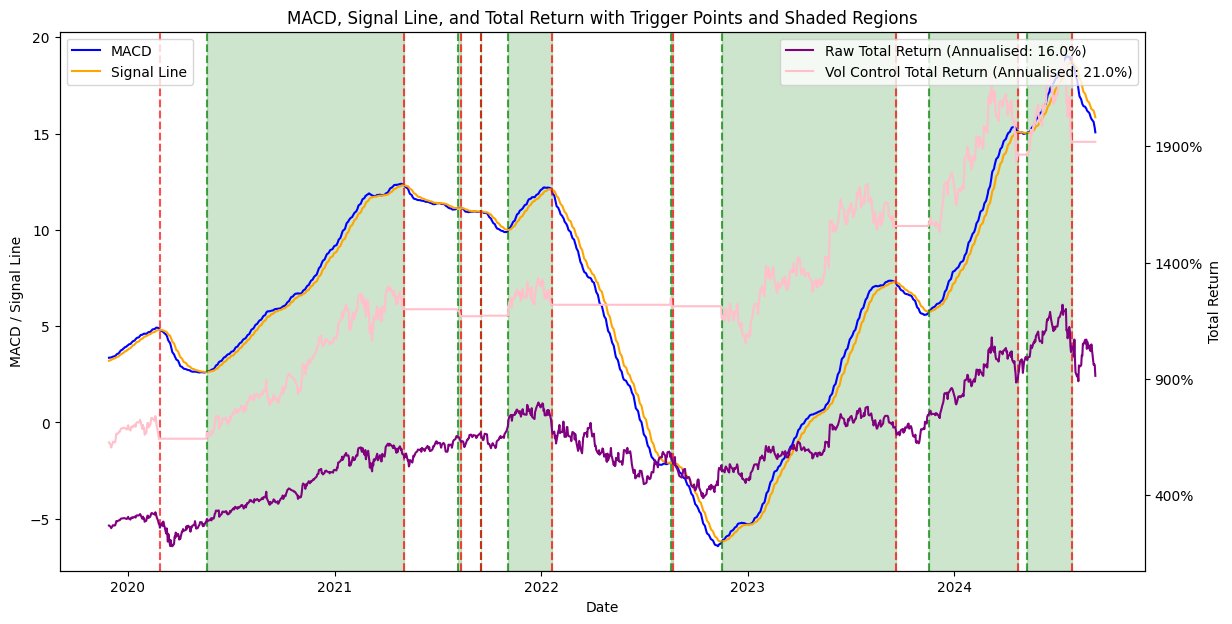

In [12]:
def macd_vis(soxx, figs_dir = "../docs/subpages_1"):
    # Ensure 'date' is set as the x-axis for plotting
    x_dates = pd.to_datetime(soxx['date'])  # Assuming 'date' is the column with date information
    
    # Create the plot with a secondary y-axis
    fig, ax1 = plt.subplots(figsize=(14, 7))
    
    # Plot MACD and Signal line on the primary y-axis (ax1)
    ax1.plot(x_dates, soxx['macd'], label='MACD', color='blue')
    ax1.plot(x_dates, soxx['signal'], label='Signal Line', color='orange')
    
    # Find where the trigger changes (from 1 to 0 or 0 to 1)
    trigger_changes = soxx['trigger'].diff().fillna(0)
    
    # Initialize variables for tracking green-red pairs
    green_start = None
    
    # Add vertical lines and highlight background
    for i in range(1, len(soxx)):
        if trigger_changes.iloc[i] == -1:  # Trigger changed from 1 to 0
            # Green line for sell signal
            ax1.axvline(x=x_dates.iloc[i], color='green', linestyle='--', alpha=0.7)
            green_start = x_dates.iloc[i]  # Mark the start of the green-red region
        elif trigger_changes.iloc[i] == 1:  # Trigger changed from 0 to 1
            # Red line for buy signal
            ax1.axvline(x=x_dates.iloc[i], color='red', linestyle='--', alpha=0.7)
            if green_start is not None:
                # Shade the region between the green and red lines
                ax1.axvspan(green_start, x_dates.iloc[i], color='green', alpha=0.2)
                green_start = None  # Reset the start marker
    
    # Labels and title for primary axis
    ax1.set_xlabel('Date')
    ax1.set_ylabel('MACD / Signal Line')
    ax1.set_title('MACD, Signal Line, and Total Return with Trigger Points and Shaded Regions')
    ax1.legend(loc='upper left')

    # Set x-axis ticks to be yearly
    ax1.xaxis.set_major_locator(mdates.YearLocator())  # Set major ticks to be at the start of each year
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Format ticks as year only

    # Create a secondary y-axis to plot total return
    ax2 = ax1.twinx()
    ax2.plot(x_dates, soxx['total_return'], label=f'Raw Total Return (Annualised: {tr*100}%)', color='purple')
    ax2.plot(x_dates, soxx['strategy_1_total_return'], label=f'Vol Control Total Return (Annualised: {strategy_1_tr*100}%)', color='pink')
    # Convert to %
    ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{(x - 1) * 100:.0f}%'))
    ax2.set_ylabel('Total Return')
    
    # Add a legend for the secondary axis
    ax2.legend(loc='upper right')

    # Save it out
    plt.savefig(os.path.join(figs_dir, "macd_vis.svg"))

    # Display the plot
    plt.show()

# Call the function with the soxx DataFrame
macd_vis(soxx[-1200:])
